In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data Preprocessing
file_path = 'Anaemia_Dataset.csv'
data = pd.read_csv(file_path)

data_cleaned = data.drop([0], axis=0)
data_cleaned.columns = data_cleaned.columns.str.strip()

cols_to_convert = ['RBC', 'PCV', 'MCV', 'MCH', 'MCHC', 'RDW', 'TLC', 'PLT /mm3', 'HGB']
data_cleaned[cols_to_convert] = data_cleaned[cols_to_convert].apply(pd.to_numeric, errors='coerce')

data_cleaned = data_cleaned.dropna(subset=['HGB'])

threshold_female = 12.0
threshold_male = 13.0

data_cleaned['Anemia'] = np.where(
    ((data_cleaned['Sex'] == 0) & (data_cleaned['HGB'] < threshold_female)) |
    ((data_cleaned['Sex'] == 1) & (data_cleaned['HGB'] < threshold_male)), 
    1, 0
)

X = data_cleaned.drop(columns=['HGB', 'Anemia'])
y = data_cleaned['Anemia']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Setting up Logistic Regression model
model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
# Accuracy, Precision, Recall, F1-Score, and ROC-AUC
accuracy = model.score(X_test, y_test)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nROC-AUC Score:", roc_auc)

Accuracy: 0.9636363636363636

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.98      0.95      0.97        62

    accuracy                           0.96       110
   macro avg       0.96      0.97      0.96       110
weighted avg       0.96      0.96      0.96       110


Confusion Matrix:
 [[47  1]
 [ 3 59]]

ROC-AUC Score: 0.9946236559139785


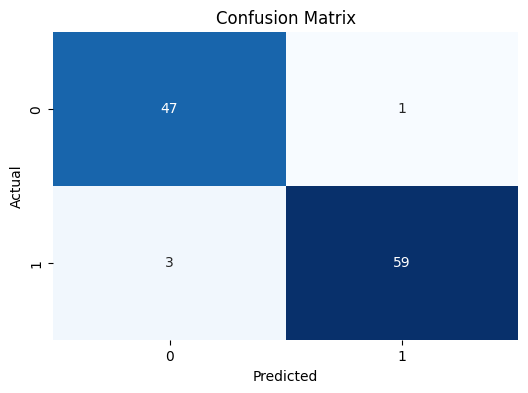

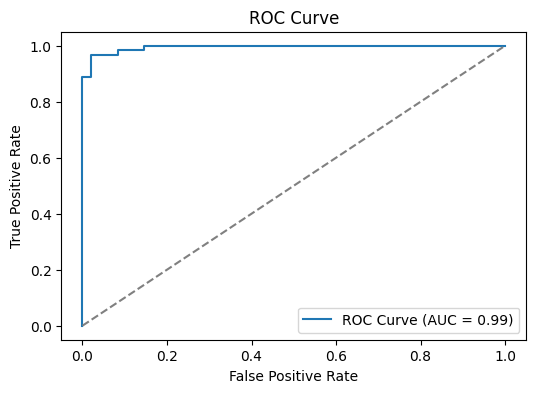

In [8]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [9]:
# Hyperparameter Tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear'] 
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [11]:
best_model = LogisticRegression(**best_params, max_iter=1000)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

accuracy_best = best_model.score(X_test, y_test)
class_report_best = classification_report(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("Tuned Model Accuracy:", accuracy_best)
print("\nTuned Classification Report:\n", class_report_best)
print("\nTuned Confusion Matrix:\n", conf_matrix_best)
print("\nTuned ROC-AUC Score:", roc_auc_best)

Tuned Model Accuracy: 0.9727272727272728

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.97      0.98      0.98        62

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110


Tuned Confusion Matrix:
 [[46  2]
 [ 1 61]]

Tuned ROC-AUC Score: 0.997983870967742


In [12]:
print(f"Original Accuracy: {accuracy:.4f}, Tuned Accuracy: {accuracy_best:.4f}")
print(f"Original ROC-AUC: {roc_auc:.4f}, Tuned ROC-AUC: {roc_auc_best:.4f}")

Original Accuracy: 0.9636, Tuned Accuracy: 0.9727
Original ROC-AUC: 0.9946, Tuned ROC-AUC: 0.9980


     Feature  Coefficient
2        Sex     4.067623
8        RDW     0.264977
9        TLC     0.057798
10  PLT /mm3     0.001165
0     S. No.     0.000878
1        Age    -0.006916
5        MCV    -0.181932
4        PCV    -0.317747
6        MCH    -0.377879
7       MCHC    -0.821100
3        RBC    -5.826056


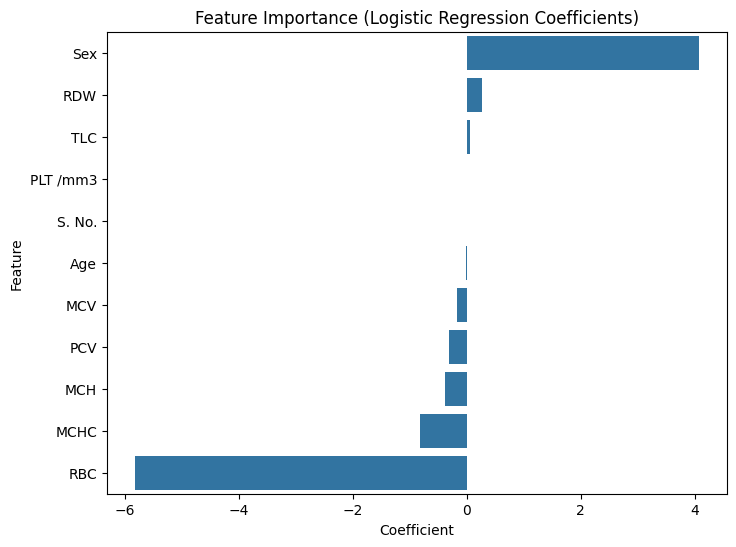

In [13]:
# Coefficient
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print(coefficients)

plt.figure(figsize=(8,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()
